<a href="https://colab.research.google.com/github/2303A51553/Natural-language-process/blob/main/2303A51553_nlp_13_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
!pip install gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 63.6 MB/s eta 0:00:00


In [7]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
df = pd.read_csv("/content/tweets.csv.zip")
print("Shape:", df.shape)
print(df.head())

Shape: (11370, 5)
   id keyword        location  \
0   0  ablaze             NaN   
1   1  ablaze             NaN   
2   2  ablaze   New York City   
3   3  ablaze  Morgantown, WV   
4   4  ablaze             NaN   

                                                text  target  
0  Communal violence in Bhainsa, Telangana. "Ston...       1  
1  Telangana: Section 144 has been imposed in Bha...       1  
2  Arsonist sets cars ablaze at dealership https:...       1  
3  Arsonist sets cars ablaze at dealership https:...       1  
4  "Lord Jesus, your love brings freedom and pard...       0  


In [8]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    text = str(text).lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return tokens
tqdm.pandas()
df['cleaned_tokens'] = df['text'].progress_apply(preprocess_text)
df['cleaned_text'] = df['cleaned_tokens'].apply(lambda x: ' '.join(x))
print("Preprocessing completed!")
print(df[['text','cleaned_text']].head())

100%|██████████| 11370/11370 [00:06<00:00, 1726.58it/s]

Preprocessing completed!
                                                text  \
0  Communal violence in Bhainsa, Telangana. "Ston...   
1  Telangana: Section 144 has been imposed in Bha...   
2  Arsonist sets cars ablaze at dealership https:...   
3  Arsonist sets cars ablaze at dealership https:...   
4  "Lord Jesus, your love brings freedom and pard...   

                                        cleaned_text  
0  communal violence bhainsa telangana stone pelt...  
1  telangana section 144 imposed bhainsa january ...  
2  arsonist set car ablaze dealership httpstcogoq...  
3  arsonist set car ablaze dealership httpstco0gl...  
4  lord jesus love brings freedom pardon fill hol...  


In [9]:
X = df['cleaned_tokens']
y = df['target']
X_train_tokens, X_test_tokens, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train_text = [' '.join(x) for x in X_train_tokens]
X_test_text = [' '.join(x) for x in X_test_tokens]
print("Train size:", len(X_train_text))
print("Test size:", len(X_test_text))

Train size: 9096
Test size: 2274


In [10]:
print("\nTraining Word2Vec model...")
w2v_model = Word2Vec(sentences=X_train_tokens,
                     vector_size=100,
                     window=5,
                     min_count=2,
                     workers=4,
                     seed=42)

def get_w2v_vector(tokens, model, size):
    valid = [t for t in tokens if t in model.wv.key_to_index]
    if len(valid) == 0:
        return np.zeros(size)
    vectors = [model.wv[t] for t in valid]
    return np.mean(vectors, axis=0)

X_train_w2v = np.vstack([get_w2v_vector(t, w2v_model, 100) for t in X_train_tokens])
X_test_w2v = np.vstack([get_w2v_vector(t, w2v_model, 100) for t in X_test_tokens])
print("Word2Vec embeddings ready!")


Training Word2Vec model...
Word2Vec embeddings ready!


In [11]:
print("\nCreating Simulated ELMo embeddings...")
tfidf = TfidfVectorizer(max_features=5000)
tfidf.fit(X_train_text)

def get_tfidf_w2v_vector(tokens, model, size, tfidf_vectorizer):
    vec = np.zeros(size)
    weight_sum = 0
    for word in tokens:
        if word in model.wv.key_to_index and word in tfidf_vectorizer.vocabulary_:
            tfidf_value = tfidf_vectorizer.idf_[tfidf_vectorizer.vocabulary_[word]]
            vec += model.wv[word] * tfidf_value
            weight_sum += tfidf_value
    if weight_sum != 0:
        vec /= weight_sum
    return vec

X_train_elmo = np.vstack([get_tfidf_w2v_vector(t, w2v_model, 100, tfidf) for t in X_train_tokens])
X_test_elmo = np.vstack([get_tfidf_w2v_vector(t, w2v_model, 100, tfidf) for t in X_test_tokens])
print("Simulated ELMo embeddings ready!")


Creating Simulated ELMo embeddings...
Simulated ELMo embeddings ready!


In [12]:
print("\nCreating Simulated BERT embeddings...")
bert_vectorizer = TfidfVectorizer(max_features=1000)
X_train_bert = bert_vectorizer.fit_transform(X_train_text).toarray()
X_test_bert = bert_vectorizer.transform(X_test_text).toarray()
print("Simulated BERT embeddings ready!")


Creating Simulated BERT embeddings...
Simulated BERT embeddings ready!


In [13]:
def evaluate_model(X_train, X_test, y_train, y_test, model_name):
    print("\n==============================")
    print("Model:", model_name)
    print("==============================")
    model = LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    print("F1 Score:", round(f1, 4))
    print("ROC-AUC :", round(roc, 4))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    return f1, roc, y_proba

f1_w2v, roc_w2v, proba_w2v = evaluate_model(X_train_w2v, X_test_w2v, y_train, y_test, "Word2Vec + Logistic Regression")
f1_elmo, roc_elmo, proba_elmo = evaluate_model(X_train_elmo, X_test_elmo, y_train, y_test, "Simulated ELMo + Logistic Regression")
f1_bert, roc_bert, proba_bert = evaluate_model(X_train_bert, X_test_bert, y_train, y_test, "Simulated BERT + Logistic Regression")





Model: Word2Vec + Logistic Regression
F1 Score: 0.4309
ROC-AUC : 0.7369
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.67      0.77      1851
           1       0.32      0.67      0.43       423

    accuracy                           0.67      2274
   macro avg       0.61      0.67      0.60      2274
weighted avg       0.79      0.67      0.71      2274


Model: Simulated ELMo + Logistic Regression
F1 Score: 0.4259
ROC-AUC : 0.7299
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.68      0.77      1851
           1       0.32      0.65      0.43       423

    accuracy                           0.68      2274
   macro avg       0.61      0.66      0.60      2274
weighted avg       0.79      0.68      0.71      2274


Model: Simulated BERT + Logistic Regression
F1 Score: 0.5987
ROC-AUC : 0.8773
Classification Report:
               precision    recall  f1-score

In [14]:

results = pd.DataFrame({
    "Embedding": ["Word2Vec", "Simulated ELMo", "Simulated BERT"],
    "F1 Score": [f1_w2v, f1_elmo, f1_bert],
    "ROC-AUC": [roc_w2v, roc_elmo, roc_bert]
})
print("\nFinal Comparison:")
print(results)


Final Comparison:
        Embedding  F1 Score   ROC-AUC
0        Word2Vec  0.430863  0.736856
1  Simulated ELMo  0.425897  0.729915
2  Simulated BERT  0.598690  0.877336


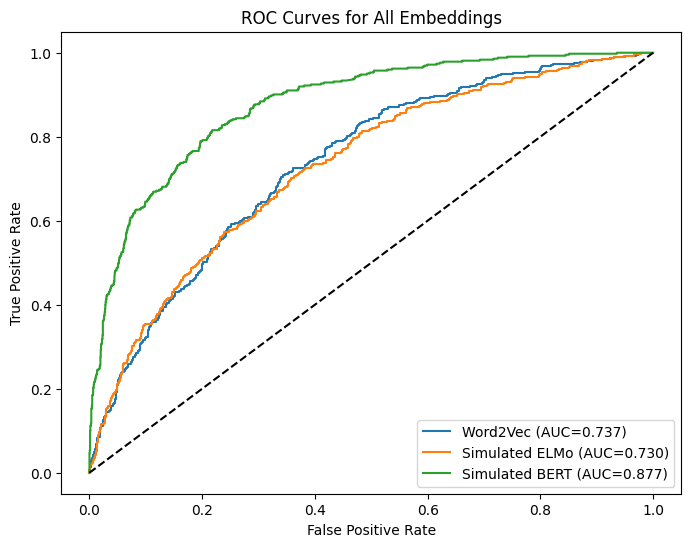

In [15]:
plt.figure(figsize=(8,6))
for name, proba in [('Word2Vec', proba_w2v), ('Simulated ELMo', proba_elmo), ('Simulated BERT', proba_bert)]:
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr, tpr):.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curves for All Embeddings")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()